# Fetching and parsing ipyrad anaconda cloud package stats
Before we delete the ipyrad anaconda package we want to look at some stats. It's been up
there for a long time and it'd be a shame not to take the opportunity to look at the package history. Luckily
anaconda provides a REST api, so we can just grab all the stats and parse them with python.

In [42]:
%matplotlib inline
import json
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
from datetime import datetime
from distutils.version import LooseVersion
from matplotlib.dates import date2num

# The REST api returns json for the package info request
with urllib.request.urlopen("https://api.anaconda.org/package/ipyrad/ipyrad") as resp:
    stats = resp.read()
stats = json.loads(stats)

# Look at the keys in this json file
stats.keys()

dict_keys(['app_entry', 'conda_platforms', 'full_name', 'owner', 'home', 'source_git_url', 'source_git_tag', 'app_type', 'upvoted', 'id', 'app_summary', 'public', 'revision', 'files', 'package_types', 'description', 'releases', 'html_url', 'builds', 'watchers', 'dev_url', 'name', 'license', 'versions', 'url', 'created_at', 'modified_at', 'latest_version', 'summary', 'license_url', 'doc_url'])

Anaconda retains information about each package version including date, number of downlads, and
much much more. This is in the 'files' key, lets look at the first one

In [20]:
v = stats["files"][0]
v

{'description': None,
 'basename': 'linux-64/ipyrad-0.6.26-0.tar.bz2',
 'labels': ['main'],
 'dependencies': {'depends': [{'name': 'bitarray', 'specs': []},
   {'name': 'cutadapt', 'specs': [['>=', '1.12']]},
   {'name': 'cython', 'specs': []},
   {'name': 'dask', 'specs': []},
   {'name': 'h5py', 'specs': []},
   {'name': 'ipyparallel', 'specs': [['>=', '5.1.0']]},
   {'name': 'ipython', 'specs': [['>=', '5.0.0']]},
   {'name': 'jupyter', 'specs': []},
   {'name': 'jupyter_client', 'specs': []},
   {'name': 'mpi4py', 'specs': []},
   {'name': 'nbconvert', 'specs': []},
   {'name': 'networkx', 'specs': []},
   {'name': 'notebook', 'specs': [['>=', '4.3']]},
   {'name': 'numba', 'specs': [['>=', '0.31']]},
   {'name': 'numpy', 'specs': [['>=', '1.7']]},
   {'name': 'pandas', 'specs': []},
   {'name': 'scipy', 'specs': [['>=', '0.16']]},
   {'name': 'sphinx', 'specs': []}]},
 'distribution_type': 'conda',
 'attrs': {'build_number': 0,
  'license': 'GPLv3',
  'has_prefix': True,
  'machin

We're not really interested in most of this, so we'll pull out the version, upload time, and
number of downloads for each package, into a tuple.

Anaconda cloud reports 10023 total downloads, but we see only 9361 in our data. This is
probably caused by having deleted packages through time, while anaconda just increments a
global counter per download.

In [88]:
dat = [(x["version"], x["upload_time"], x["ndownloads"]) for x in stats["files"]]
print(len(dat), np.sum([x[2] for x in dat]))
dat[:5]

181 9361


[('0.6.26', '2017-06-01 18:47:50.246000+00:00', 23),
 ('0.4.6', '2016-10-31 21:41:33.711000+00:00', 19),
 ('0.4.6', '2016-10-31 21:41:47.220000+00:00', 3),
 ('0.7.28', '2018-07-22 18:51:45.998000+00:00', 380),
 ('0.4.0', '2016-09-30 16:49:20.595000+00:00', 3)]

Lets pull out the linux ones for now.

In [89]:
dat = [(x["version"], x["upload_time"], x["ndownloads"]) for x in stats["files"] if "linux" in x["basename"]]
print(len(dat), np.sum([x[2] for x in dat]))
dat[:5]

96 7755


[('0.6.26', '2017-06-01 18:47:50.246000+00:00', 23),
 ('0.4.6', '2016-10-31 21:41:33.711000+00:00', 19),
 ('0.7.28', '2018-07-22 18:51:45.998000+00:00', 380),
 ('0.4.0', '2016-09-30 16:49:45.436000+00:00', 8),
 ('0.4.1', '2016-10-01 17:00:45.291000+00:00', 20)]

Redo the list comprehension and include a few conversions that'll make things easier later.
Semantic versioning is so common there's a mondule for representing it in python, and you can
even sort them, super convenient. Also, convert the date to a datetime object, so we can compare
them easier.

In [93]:
dat = [(LooseVersion(x["version"]),
        datetime.strptime(x["upload_time"].split(".")[0].split("+")[0], "%Y-%m-%d %H:%M:%S"),
        x["ndownloads"]) for x in stats["files"]
        if "linux" in x["basename"]]
dat[:5]

[(LooseVersion ('0.6.26'), datetime.datetime(2017, 6, 1, 18, 47, 50), 23),
 (LooseVersion ('0.4.6'), datetime.datetime(2016, 10, 31, 21, 41, 33), 19),
 (LooseVersion ('0.7.28'), datetime.datetime(2018, 7, 22, 18, 51, 45), 380),
 (LooseVersion ('0.4.0'), datetime.datetime(2016, 9, 30, 16, 49, 45), 8),
 (LooseVersion ('0.4.1'), datetime.datetime(2016, 10, 1, 17, 0, 45), 20)]

First of all it's out of order, so lets sort by version number. 

In [94]:
dat = sorted(dat, key=lambda x: x[0])
dat[-5:]

[(LooseVersion ('0.7.28'), datetime.datetime(2018, 11, 22, 18, 11, 45), 302),
 (LooseVersion ('0.7.29'), datetime.datetime(2019, 1, 21, 18, 51, 41), 453),
 (LooseVersion ('0.7.30'), datetime.datetime(2019, 3, 9, 19, 31, 50), 3),
 (LooseVersion ('0.7.30'), datetime.datetime(2019, 3, 9, 21, 26, 17), 102),
 (LooseVersion ('0.7.30'), datetime.datetime(2019, 3, 29, 3, 59, 16), 618)]

Lets look at the release schedule, so plot version number by date

96


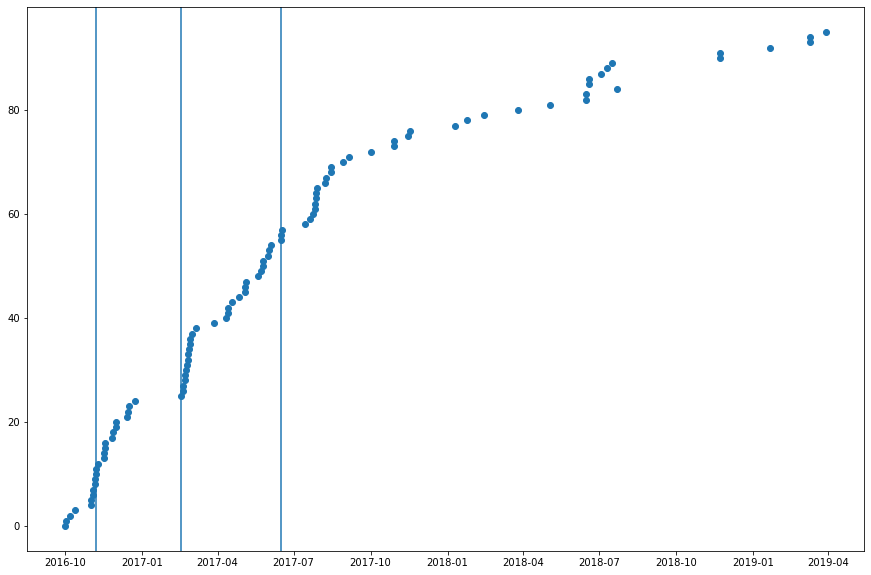

In [95]:
print(len(dat))
ys = range(0, len(dat))
fig, ax = plt.subplots(figsize=(15, 10))
ax = plt.plot_date([date2num(x[1]) for x in dat], ys)

# Add vertical bars for minor version updates
release_05 = [x for x in dat if str(x[0]) == "0.5.0"][0]
release_06 = [x for x in dat if str(x[0]) == "0.6.0"][0]
release_07 = [x for x in dat if str(x[0]) == "0.7.0"][0]

#ax.axvline(x=0, ymin=0, ymax=175)
plt.axvline(release_05[1])
plt.axvline(release_06[1])
plt.axvline(release_07[1])

This is another view on time, except now we'll plot how long each version 'lasted', the duration of
time between releases.

/home/isaac/miniconda3/envs/ipyrad_py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


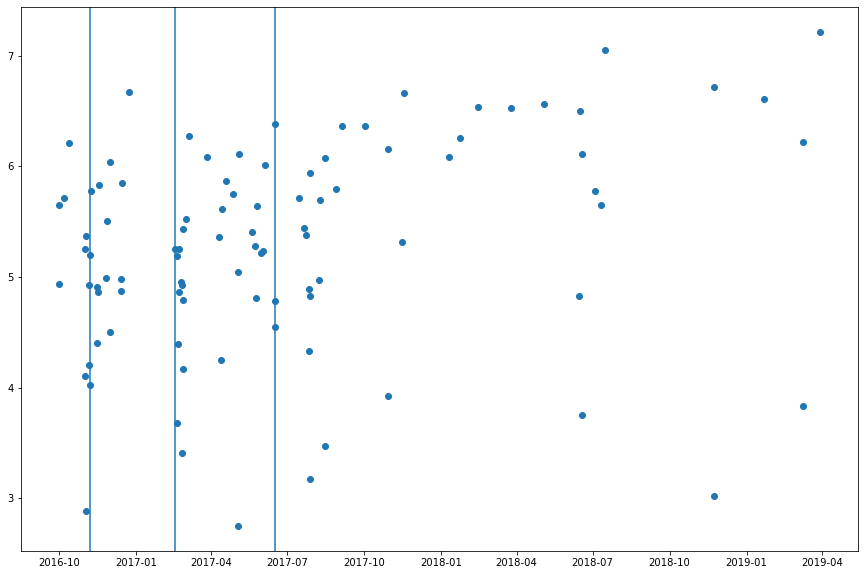

In [107]:
# Now ys will be download count
v9_rollout = datetime.strptime("2019-10-5 00:00:01", "%Y-%m-%d %H:%M:%S")

dates = np.array([x[1] for x in dat])
dates_shift = [x[1] for x in dat][1:]
dates_shift.append(v9_rollout)
date_shift = np.array(dates_shift)

transit_time = dates_shift - dates
ys = [np.log10(x.total_seconds()) for x in transit_time]
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot_date([date2num(x[1]) for x in dat], ys)

# Add vertical bars for minor version updates
release_05 = [x for x in dat if str(x[0]) == "0.5.0"][0]
release_06 = [x for x in dat if str(x[0]) == "0.6.0"][0]
release_07 = [x for x in dat if str(x[0]) == "0.7.0"][0]

#ax.axvline(x=0, ymin=0, ymax=175)
plt.axvline(release_05[1])
plt.axvline(release_06[1])
plt.axvline(release_07[1])

Now lets check out the download history

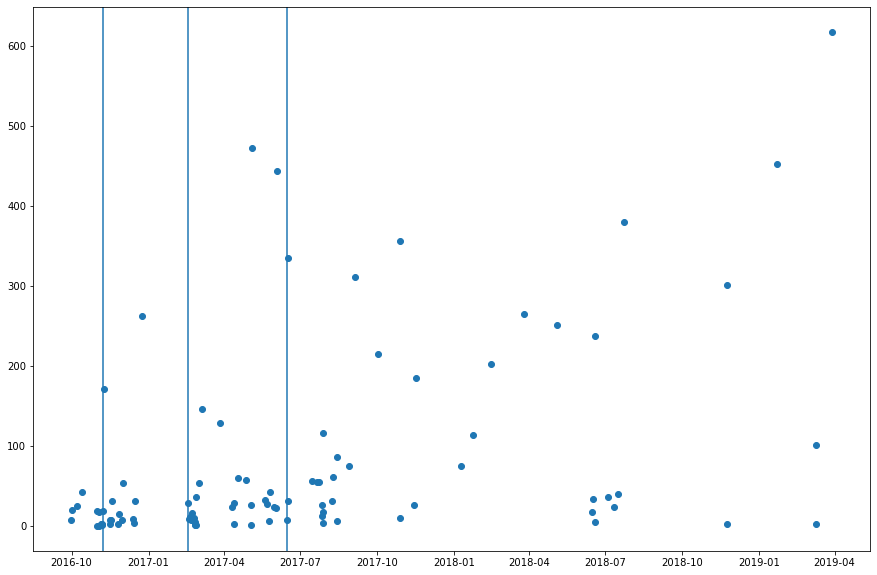

In [96]:
# Now ys will be download count
ys = [x[2] for x in dat]
fig, ax = plt.subplots(figsize=(15, 10))
ax = plt.plot_date([date2num(x[1]) for x in dat], ys)

# Add vertical bars for minor version updates
release_05 = [x for x in dat if str(x[0]) == "0.5.0"][0]
release_06 = [x for x in dat if str(x[0]) == "0.6.0"][0]
release_07 = [x for x in dat if str(x[0]) == "0.7.0"][0]

#ax.axvline(x=0, ymin=0, ymax=175)
plt.axvline(release_05[1])
plt.axvline(release_06[1])
plt.axvline(release_07[1])

## Do bioconda

In [108]:
with urllib.request.urlopen("https://api.anaconda.org/package/bioconda/ipyrad") as resp:
    stats = resp.read()
stats = json.loads(stats)
dat = [(LooseVersion(x["version"]),
        datetime.strptime(x["upload_time"].split(".")[0].split("+")[0], "%Y-%m-%d %H:%M:%S"),
        x["ndownloads"]) for x in stats["files"]
      ]
dat = sorted(dat, key=lambda x: x[0])
dat[:5]

[(LooseVersion ('0.9.7'), datetime.datetime(2019, 6, 9, 19, 36, 39), 60),
 (LooseVersion ('0.9.8'), datetime.datetime(2019, 6, 10, 23, 3, 27), 68),
 (LooseVersion ('0.9.10'), datetime.datetime(2019, 6, 15, 22, 17, 20), 90),
 (LooseVersion ('0.9.11'), datetime.datetime(2019, 7, 26, 20, 54, 4), 62),
 (LooseVersion ('0.9.11'), datetime.datetime(2019, 8, 16, 7, 14, 26), 37)]

27


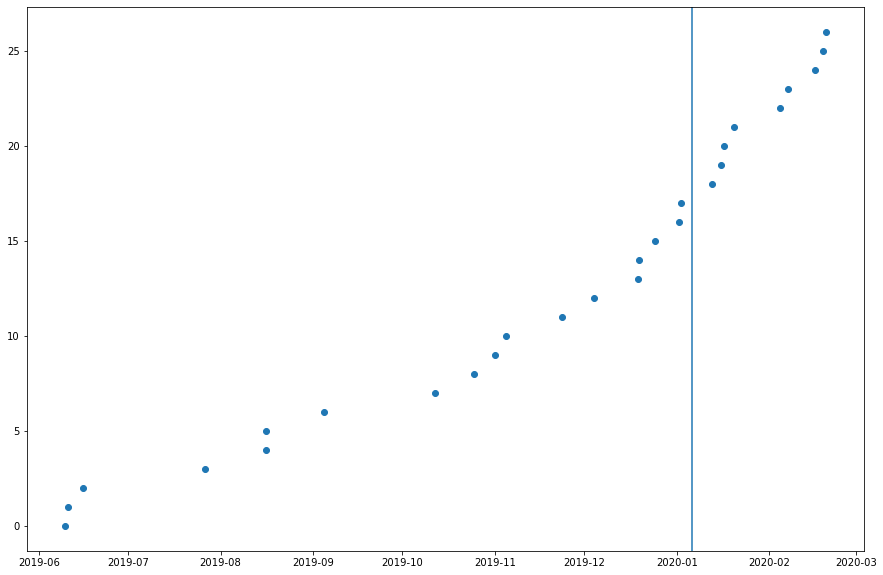

In [110]:
print(len(dat))
manu_published = datetime.strptime("2020-01-06 00:00:01", "%Y-%m-%d %H:%M:%S")

ys = range(0, len(dat))
fig, ax = plt.subplots(figsize=(15, 10))
ax = plt.plot_date([date2num(x[1]) for x in dat], ys)

plt.axvline(manu_published)

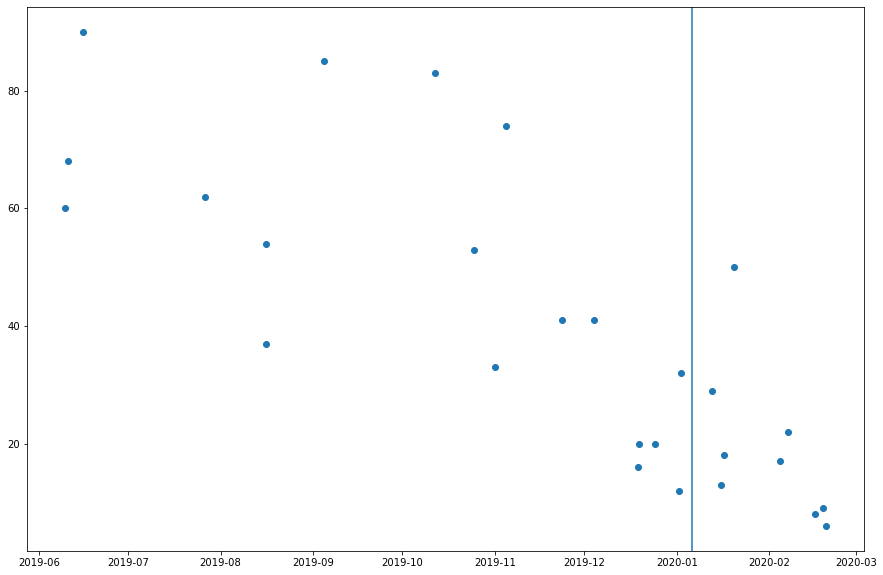

In [111]:
# Now ys will be download count
ys = [x[2] for x in dat]
fig, ax = plt.subplots(figsize=(15, 10))
ax = plt.plot_date([date2num(x[1]) for x in dat], ys)
manu_published = datetime.strptime("2020-01-06 00:00:01", "%Y-%m-%d %H:%M:%S")
plt.axvline(manu_published)

In [127]:
import os
import ipyrad

data = ipyrad.load_json("/tmp/ipyrad-test/peddrad22.json")
data.set_params("sorted_fastq_path", "~/../../tmp/ipyrad-test/peddrad22_fastqs/*.gz")
print(data.params.sorted_fastq_path)

#os.path.realpath("~/tmp")
data.params.sorted_fastq_path.rsplit("/", 1)[0]

loading Assembly: peddrad22
from saved path: /tmp/ipyrad-test/peddrad22.json
/tmp/ipyrad-test/peddrad22_fastqs/*.gz


'/tmp/ipyrad-test/peddrad22_fastqs'

In [124]:
!ls /tmp/ipyrad-test/

analysis-bucky	      peddrad22_consens  peddrad22.json
peddrad22_across      peddrad22_edits	 peddrad22_outfiles
peddrad22_clust_0.85  peddrad22_fastqs	 peddrad22_refmapping
